We start by interpolating the thermophysical properties of the solid:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from deepxde.backend import tf
import seaborn as sns
sns.set_context('talk')

In [16]:
T = np.array([20, 100, 200, 300, 400]) + 273.15
k_s = np.array([147, 155, 159, 159, 155])
c = np.array([739, 755, 797, 838, 922])

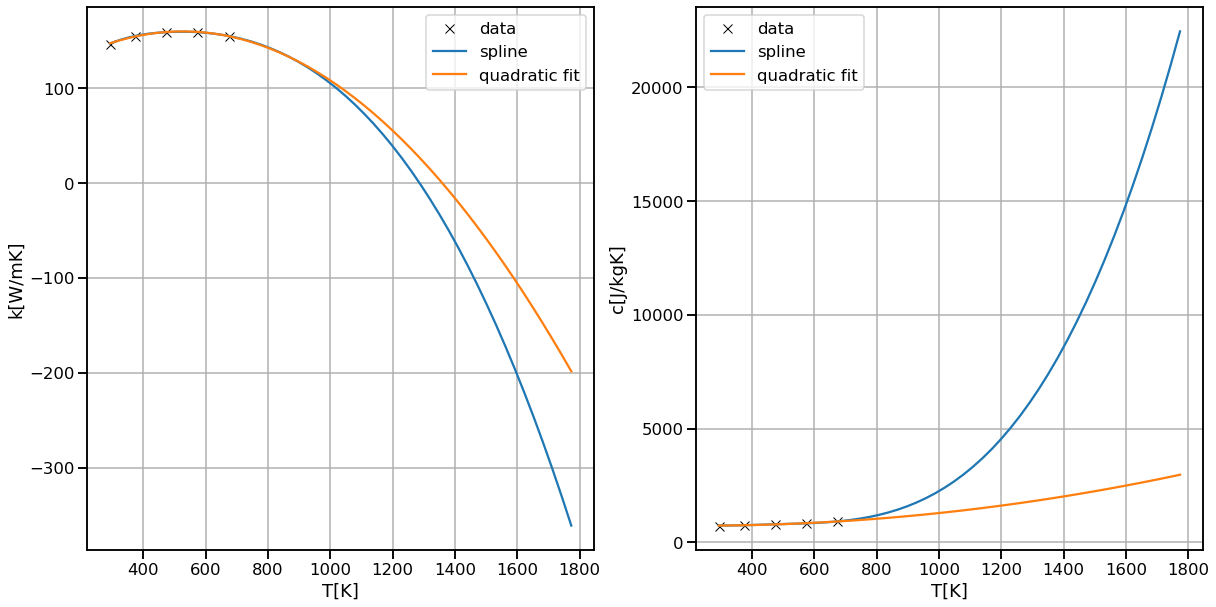

In [17]:
from scipy.optimize import curve_fit

T_range = np.linspace(20, 1500) + 273.15

def func(x, a, b, c):
    return a + b*x + c*x**2

k_interpolate = scipy.interpolate.CubicSpline(T, k_s)
c_interpolate = scipy.interpolate.CubicSpline(T, c)

p_k, q_k = curve_fit(func, T, k_s)
p_c, q_c = curve_fit(func, T, c)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

ax1.plot(T, k_s, 'kx', label = 'data')
ax1.plot(T_range, k_interpolate(T_range), label = 'spline')
ax1.plot(T_range, func(T_range, p_k[0], p_k[1], p_k[2]), label = 'quadratic fit')
ax1.set_xlabel('T[K]')
ax1.set_ylabel('k[W/mK]')
ax1.grid()
ax1.legend()

ax2.plot(T, c, 'kx', label = 'data')
ax2.plot(T_range, c_interpolate(T_range), label = 'spline')
ax2.plot(T_range, func(T_range, p_c[0], p_c[1], p_c[2]), label = 'quadratic fit')
ax2.set_xlabel('T[K]')
ax2.set_ylabel('c[J/kgK]')
ax2.grid()
ax2.legend()

Defining the geometry of the powderbed:

In [18]:
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x_max = 1.54e-3
y_max = 0.7e-3/3
z_max = 0.1e-3/3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

Set the default float type to float64


Defining the time and the domian:

In [19]:
t_max = 0.005

time = dde.geometry.TimeDomain(0.0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [20]:
rho = 2650.0
A = 0.09
D = 70e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

In [21]:
def top_bc(X):
    
    r_sq = (X[:,0] - x_max/4 - X[:,3]*v)**2 + (X[:,1] - y_max/2)**2
    
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

Plotting the end position of teh laser beam on the surface

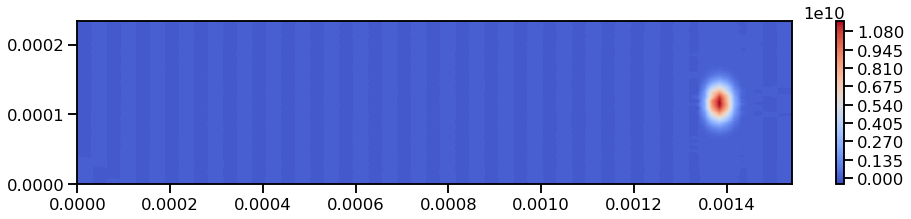

In [24]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0.005])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), top_bc(X), (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

defining the pde system:

In [25]:
def pde_system(X, output):#
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    #k_eff = func(T, p_k[0], p_k[1], p_k[2])
    #c_eff = func(T, p_c[0], p_c[1], p_c[2])
    
    k_eff = 155
    c_eff = 922
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho*c_eff)
    
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [26]:
def top_bc_new(X):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)

ic = dde.icbc.IC(domain, lambda on_initial: 20.0 + T_0, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, y : top_bc_new(X)/155.0, lambda x, on_boundary: on_boundary and np.isclose(x[2], z_max, atol=z_max/10))
sides = dde.icbc.DirichletBC(domain, lambda X : 20.0 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z_max, atol=z_max/10))

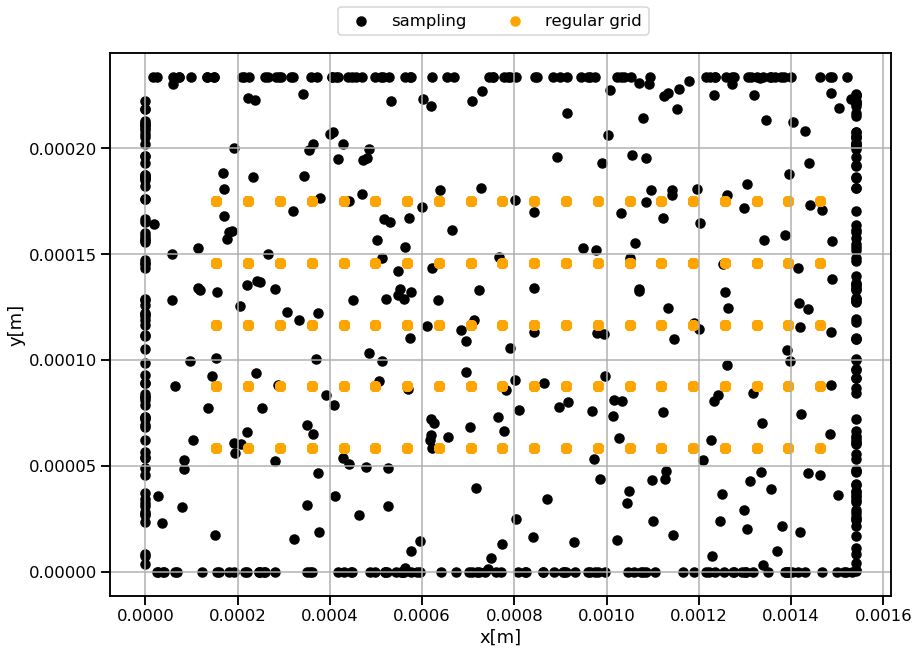

In [81]:
#setting training points at the important part of the boundary
x_lin = np.linspace(0.1*x_max, 0.95*x_max, 20)
y_lin = np.linspace(0.25*y_max, 0.75*y_max, 5)
z_lin = np.linspace(0.5*z_max, z_max, 10)
t_lin = np.linspace(0, t_max, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_lin], [t_lin])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top, sides],
                       num_domain = 100,
                       num_initial = 0,
                       num_boundary = 500,
                       train_distribution="pseudo")

points = data.train_points().T
    
plt.figure(figsize = (14, 10))
plt.scatter(points[0], points[1], c = 'black', label = 'sampling', marker = 'o')
plt.scatter(X.T[0], X.T[1], c = 'orange', label = 'regular grid', marker = 'o')
#plt.colorbar()
#plt.title('importance sampling')
plt.grid()
plt.legend(bbox_to_anchor = (0.7, 1.1), ncol = 2)
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.savefig('importance.png')

creating the dataset:

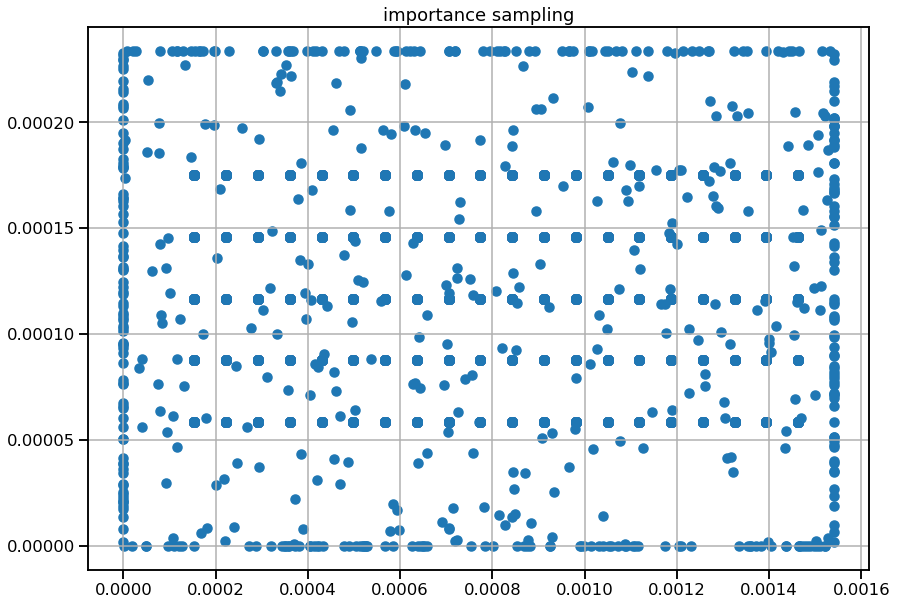

In [83]:
#setting training points at the important part of the boundary
x_lin = np.linspace(0.1*x_max, 0.95*x_max, 20)
y_lin = np.linspace(0.25*y_max, 0.75*y_max, 5)
z_lin = np.linspace(0.5*z_max, z_max, 10)
t_lin = np.linspace(0, t_max, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_lin], [t_lin])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top, sides],
                       num_domain = 100,
                       num_initial = 0,
                       num_boundary = 500,
                       train_distribution="pseudo",
                       anchors=X)

points = data.train_points().T
    
plt.figure(figsize = (14, 10))
plt.scatter(points[0], points[1])
#plt.colorbar()
plt.title('importance sampling')
plt.grid()

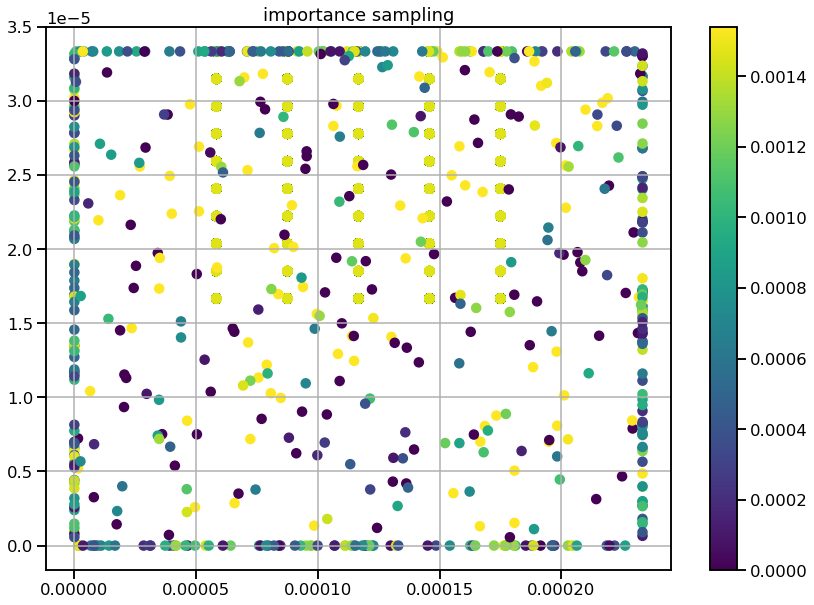

In [84]:
plt.figure(figsize = (14, 10))
plt.scatter(points[1], points[2], c = points[0])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

In [85]:
#net = dde.nn.FNN([4] + [100] * 4 + [1], "sin", "Glorot normal")
net = dde.nn.MsFFN([4] + [60] * 4 + [1], "sin", "Glorot normal", sigmas = [1e-1, 1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x_max, 
         X[:, 1:2]/y_max,
         X[:, 2:3]/z_max,
         X[:, 3:4]/t_max], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = t*Temperature*1000*1e1 + 20.0 + T_0
    return T_new
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-05-29 16:55:04.241762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 16:55:04.375180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 16:55:04.376751: I tensorflow/stream_execu

'compile' took 4.512480 s



In [18]:
losshistory, train_state = model.train(epochs=0, display_every=1000)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.38e+12, 2.70e+13, 5.90e+02]    [5.38e+12, 2.70e+13, 5.90e+02]    []  

Best model at step 0:
  train loss: 3.24e+13
  test loss: 3.24e+13
  test metric: []

'train' took 1.286020 s



In [19]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1, 1e2])
model.compile("adam", lr=1e-3, loss_weights=weights*weights_2)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=2000, display_every=100)

Compiling model...
'compile' took 1.581454 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.30e-01, 9.87e-01, 3.62e+01]    [1.30e-01, 9.87e-01, 3.62e+01]    []  
100       [8.86e-03, 9.95e-01, 3.50e-02]    [8.86e-03, 9.95e-01, 3.50e-02]    []  
200       [6.17e-03, 9.95e-01, 1.33e-02]    [6.17e-03, 9.95e-01, 1.33e-02]    []  
300       [4.47e-03, 9.96e-01, 7.65e-03]    [4.47e-03, 9.96e-01, 7.65e-03]    []  
400       [3.46e-03, 9.96e-01, 5.38e-03]    [3.46e-03, 9.96e-01, 5.38e-03]    []  
500       [2.80e-03, 9.96e-01, 4.09e-03]    [2.80e-03, 9.96e-01, 4.09e-03]    []  
600       [2.37e-03, 9.96e-01, 3.23e-03]    [2.37e-03, 9.96e-01, 3.23e-03]    []  
700       [2.06e-03, 9.96e-01, 2.62e-03]    [2.06e-03, 9.96e-01, 2.62e-03]    []  
800       [1.85e-03, 9.95e-01, 2.17e-03]    [1.85e-03, 9.95e-01, 2.17e-03]    []  
900       [1.70e-03, 9.95e-01, 1.84e-03]    [1.70e-03, 9.95e-01, 1.84e-0

In [20]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 3.798997 s

Training model...

Step      Train loss                        Test loss                         Test metric
2000      [1.22e-03, 9.94e-01, 7.36e-04]    [1.22e-03, 9.94e-01, 7.36e-04]    []  
2100      [2.36e-03, 9.87e-01, 1.81e-03]                                          
2200      [3.67e-03, 9.79e-01, 2.80e-03]                                          
2300      [4.33e-03, 9.70e-01, 2.31e-03]                                          
2400      [6.47e-03, 9.57e-01, 2.94e-03]                                          
2500      [7.24e-03, 9.48e-01, 2.91e-03]                                          
2600      [8.96e-03, 9.34e-01, 4.29e-03]                                          
2700      [1.20e-02, 9.12e-01, 6.76e-03]                                          
2800      [2.28e-02, 8.73e-01, 9.48e-03]                                          
2900      [2.32e-02, 8.37e-01, 8.64e-03]                                          
3000      [3.53

In [21]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=5000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*np.array([1, 1, 1e3]))
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 3.800907 s

Training model...

Step      Train loss                        Test loss                         Test metric
3039      [3.70e-02, 7.53e-01, 1.13e-01]    [3.70e-02, 7.53e-01, 1.13e-01]    []  
3100      [3.72e-02, 7.54e-01, 4.30e-02]                                          
3200      [3.11e-02, 7.54e-01, 1.35e-02]                                          
3300      [2.81e-02, 7.49e-01, 7.81e-03]                                          
3400      [2.79e-02, 7.35e-01, 7.24e-03]                                          
3500      [3.28e-02, 7.11e-01, 8.89e-03]                                          
3600      [3.40e-02, 6.89e-01, 1.11e-02]                                          
3700      [4.10e-02, 6.57e-01, 1.27e-02]                                          
3800      [4.69e-02, 6.26e-01, 1.33e-02]                                          
3900      [4.91e-02, 5.97e-01, 1.44e-02]                                          
4000      [4.85

In [22]:
model.save('small/')

INFO:tensorflow:small/-8307.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'small/-8307.ckpt'

In [86]:
model.restore('small/-8307.ckpt')

INFO:tensorflow:Restoring parameters from small/-8307.ckpt


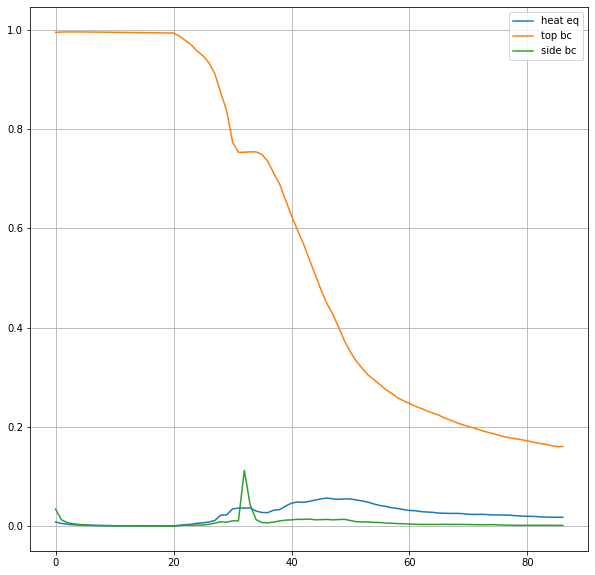

In [24]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 2
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

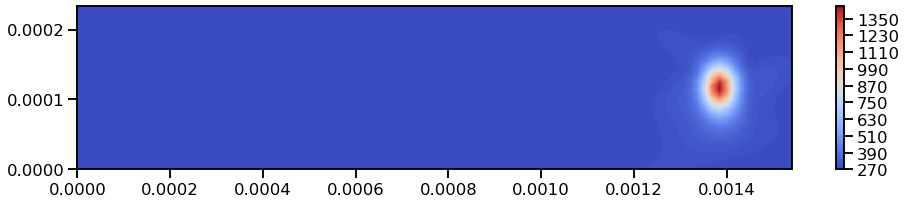

In [89]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

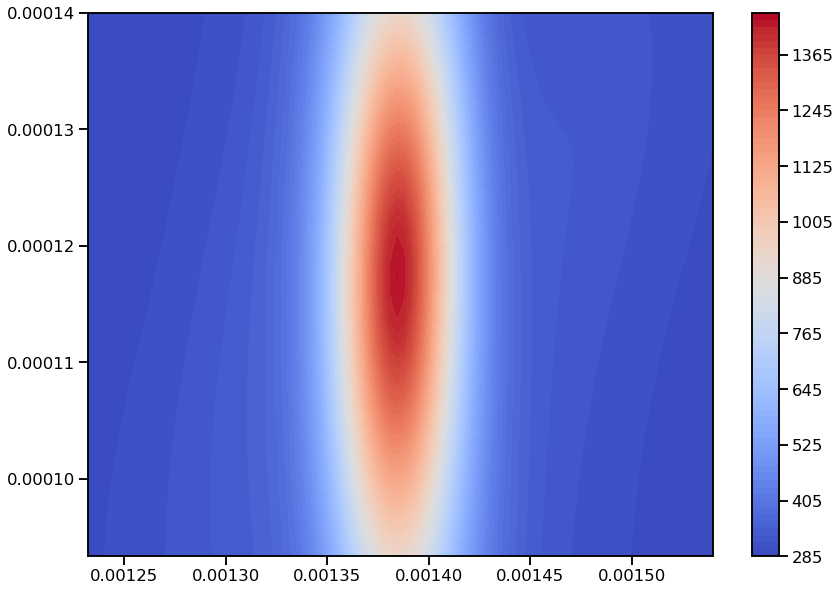

In [90]:
x_lin = np.linspace(0.8*x_max, x_max)
y_lin = np.linspace(0.4*y_max, 0.6*y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

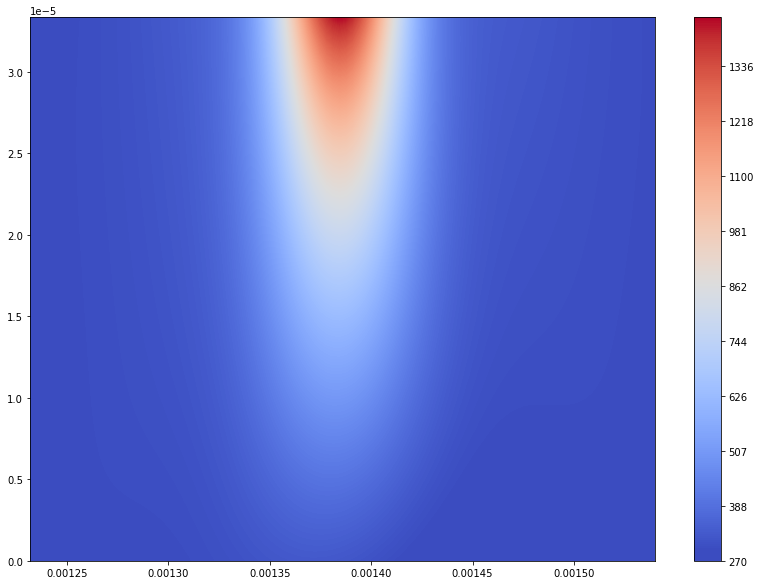

In [17]:
x_lin = np.linspace(0.8*x_max, x_max)
z_lin = np.linspace(0, z_max)
xx, yy, zz, tt = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 1000, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

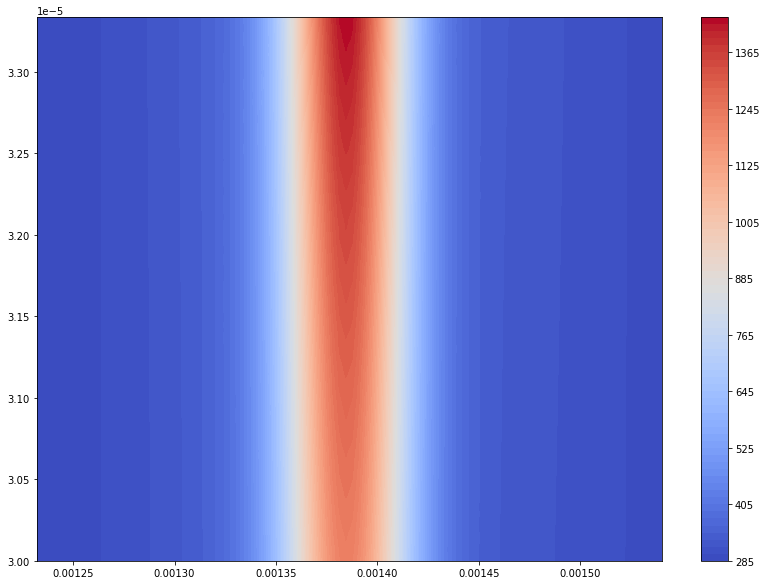

In [18]:
x_lin = np.linspace(0.8*x_max, x_max)
z_lin = np.linspace(0.9*z_max, z_max)
xx, yy, zz, tt = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

<IPython.core.display.Javascript object>


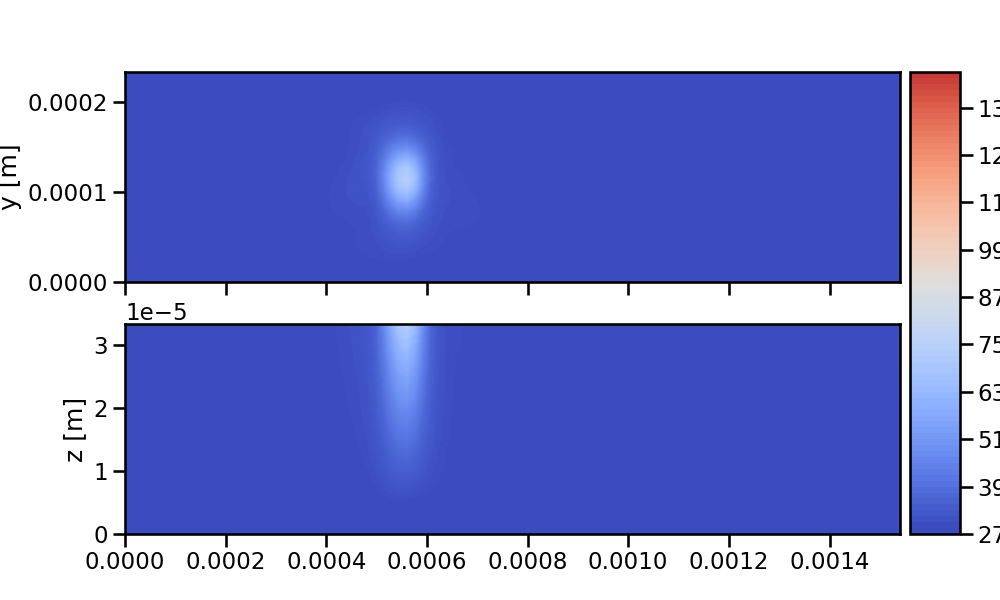

In [109]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (10, 6), sharex=True)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
z_lin = np.linspace(0, z_max)

xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
ax1.set_ylabel('y [m]')
#plt.colorbar(CS, ax = ax1)

xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
Y2 = model.predict(X2)

xi2 = np.linspace(xx2.min(), xx2.max(), 100)
zi2 = np.linspace(zz2.min(), zz2.max(), 100)
data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

CS2 = ax2.contourf(xi2, zi2, data2, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
ax2.set_ylabel('z [m]')
#plt.colorbar(CS2, ax = ax2)

cbar_ax = fig.add_axes([0.91, 0.11, 0.05, 0.77])
fig.colorbar(CS, cax=cbar_ax)

def animate(i):

    xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [i/100*t_max])
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
    Y = model.predict(X)

    xi = np.linspace(xx.min(), xx.max(), 100)
    yi = np.linspace(yy.min(), yy.max(), 100)
    data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

    CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
    
    xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [i/100*t_max])
    X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
    Y2 = model.predict(X2)

    xi2 = np.linspace(xx2.min(), xx2.max(), 100)
    zi2 = np.linspace(zz2.min(), zz2.max(), 100)
    data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

    CS2 = ax2.contourf(xi2, zi2, data2, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
            
FuncAnimation(fig, animate, frames = 100, interval=100)

<IPython.core.display.Javascript object>


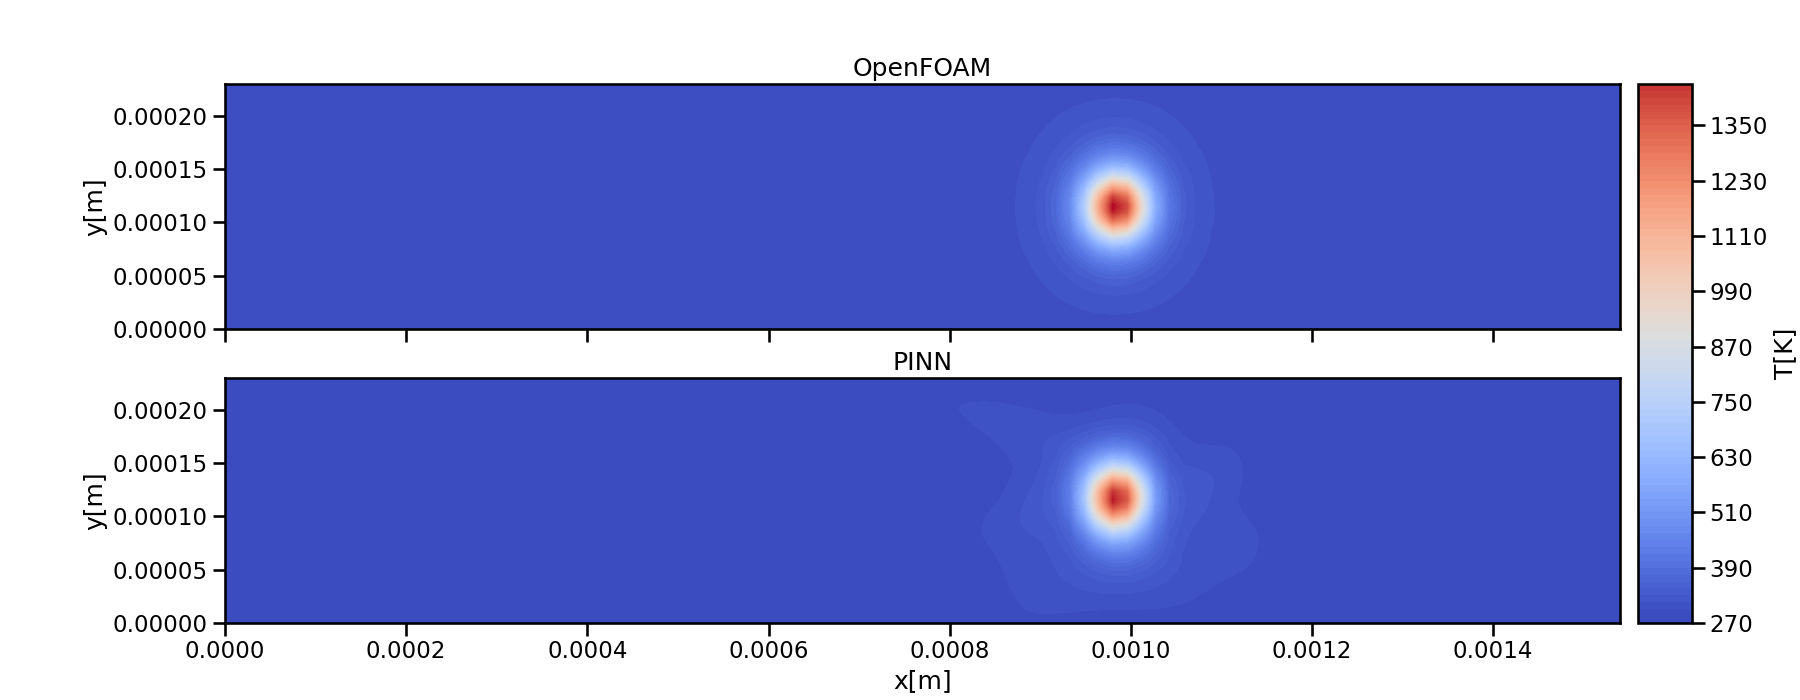

In [115]:
slice_data = np.genfromtxt('of_phase/slice1/slice_124.csv', delimiter = ',',skip_header = True)

x = slice_data[:,0]
y = slice_data[:,1]
z = slice_data[:,2]
T = slice_data[:,3]

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(CS, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

def animate(i):
    
    slice_data = np.genfromtxt('of_phase/slice1/slice_{}.csv'.format(i), delimiter = ',',skip_header = True)
    T = slice_data[:,3]
    
    #xx, yy, zz, tt = np.meshgrid(x, y, [z.max], [(i+1)/125*t_max])
    X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max/125*(i+1))).T
    Y = model.predict(X)
    
    Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
    T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
    im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
    CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
            
anim = FuncAnimation(fig, animate, frames = 100, interval = 50)
from matplotlib.animation import FFMpegWriter

writervideo = FFMpegWriter(fps=60)
anim.save('pictures/video.mp4', writer=writervideo)

In [62]:
x

array([1.5400e-05, 0.0000e+00, 1.5400e-05, ..., 1.5092e-03, 1.5246e-03,
       1.5400e-03])

In [72]:
T.max()

1432.8

In [73]:
data.min()

280.55416901038046

In [74]:
ref_data = np.genfromtxt('of_phase/csvs/data_124.csv', delimiter = ',',skip_header = True)

In [34]:
ref_data.shape

(108171, 14)

In [75]:
X = ref_data[:,0:3].T
t_value = np.ones(len(X[0]))*t_max
X = np.vstack((X, t_value)).T

In [76]:
Y = model.predict(X)

In [77]:
Y.max()

1408.2578435125047

In [78]:
diff = np.abs(Y.T[0] - ref_data[:,3:4].T)

In [79]:
diff.mean()

2.448570428234373

In [80]:
np.sqrt(diff.var())

5.045113197956027

In [81]:
diff.max()

85.96034362426326

In [82]:
diff.min()

2.838474284772019e-05

(array([6.44497059e-01, 4.20028653e-01, 2.87984619e-01, 2.09046420e-01,
        1.76180597e-01, 1.41099343e-01, 8.08309955e-02, 4.91481705e-02,
        3.89959007e-02, 2.81768505e-02, 2.00679401e-02, 1.51853866e-02,
        1.25827920e-02, 1.08190502e-02, 9.61454363e-03, 9.03379939e-03,
        8.45305514e-03, 6.96893096e-03, 6.36667766e-03, 6.00102388e-03,
        6.56025908e-03, 5.61386105e-03, 5.65687914e-03, 5.22669822e-03,
        4.40935446e-03, 4.90406252e-03, 4.38784542e-03, 4.06520972e-03,
        4.08671877e-03, 3.95766449e-03, 3.65653785e-03, 3.76408308e-03,
        3.46295643e-03, 3.09730265e-03, 2.88221219e-03, 2.98975742e-03,
        2.77466695e-03, 2.47354031e-03, 2.17241366e-03, 2.47354031e-03,
        2.34448603e-03, 1.89279606e-03, 2.34448603e-03, 2.43052222e-03,
        2.27995889e-03, 1.65619655e-03, 1.84977797e-03, 2.32297699e-03,
        1.91430511e-03, 1.48412418e-03, 2.08637748e-03, 1.63468751e-03,
        1.72072369e-03, 1.91430511e-03, 1.67770560e-03, 2.215431

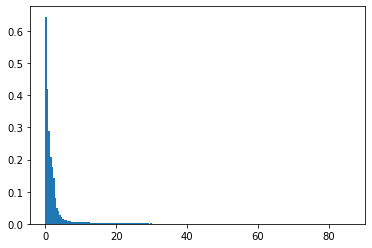

In [90]:
%matplotlib inline
plt.hist(diff[0], bins = 200, density=True)

In [85]:
diff[0].shape

(108171,)